# Supervised outlier detection

## How to use the notebook

The following cells:
- specify objective, variables, and data types,
- set up the outlier detection models,
- read dataset,
- present results from the models.

To just see how it works for a toy example, simply run the whole notebook as is.

For your own project, adjust the details about objectives, variables, dataset etc. and then execute all cells in order.
The board "supervised.board" will help you with detailed instructions.

# Imports and General Setup
Requires imbalanced-learn

In [1]:
import os
import shutil
from distutils.dir_util import copy_tree

import time
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import classification_report, plot_roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=FutureWarning)

from joblib import dump, load

# Project

In [2]:
experiment_name = {{cookiecutter.project_name}}  # please provide a name for the outlier detection experiment

# Dataset

In [3]:
time_series = True # Specify if the data is time series
path = '{{cookiecutter.data_path}}' # Specify the path of the data
test_size = 0.25

if path == 'default example':
    path = 'https://raw.githubusercontent.com/erium/halerium-example-data/main/outlier_detection/cpu4.csv'

if time_series:
    df = pd.read_csv(path, parse_dates=['date'], index_col = 'date')
else:
    df = pd.read_csv(path)

num_col = len(df.columns)

path = './../out'
isExist = os.path.exists(path)
if isExist:
  for root, dirs, files in os.walk(path):
      for f in files:
          os.unlink(os.path.join(root, f))
      for d in dirs:
          shutil.rmtree(os.path.join(root, d))
else:
  os.makedirs(path)

## Visualising the dataset

In [4]:
print('Number of outliers: ', len(df[df['outlier'] == 1]))
df

Number of outliers:  209


,value,outlier
date,,
1469376000,0.847300,0
1469376300,-0.036137,0
1469376600,0.074292,0
1469376900,0.074292,0
1469377200,-0.036137,0
...,...,...
1474644900,0.074292,0
1474645200,0.295152,0
1474645500,0.074292,0


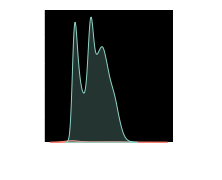

In [5]:
pairplot_hue = 'outlier'
palette ={0: "C0", 1: "C3"}
sns.pairplot(df, hue = pairplot_hue, palette=palette)

In [6]:
X = df.drop(columns='outlier')
y = df['outlier']

labels = list(X.columns)
num_labels = len(labels)
print(labels)

['value']


Split train and test data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

# Dealing with imbalanced data

In [8]:
data_skew = pd.Series({'Non-outlier': len(y_train.loc[y_train == 0]), 'Outlier': len(y_train.loc[y_train == 1])})
print(data_skew)

Non-outlier    13013
Outlier          163
dtype: int64


In [9]:
 balance_data = 'smote' # 'smote', 'oversampling', or 'none'

In [10]:
if balance_data == 'oversampling':
    ros = RandomOverSampler()
    X_train, y_train = ros.fit_resample(X_train, y_train)
elif balance_data == 'smote':
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)
data_skew = pd.Series({'Non-outlier': len(y_train.loc[y_train == 0]), 'Outlier': len(y_train.loc[y_train == 1])})
print(data_skew)

Non-outlier    13013
Outlier        13013
dtype: int64


# Normalising the data

In [11]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

dump(scaler, path + '/scaler.joblib')

['./../out/scaler.joblib']

# Classification Models

In [12]:
run_models = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes", "QDA"]
run_models_data = {}
num_models = len(run_models)

models = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process", # May be quite slow
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]


## K Nearest Neighbors

Running K Nearest Neighbors


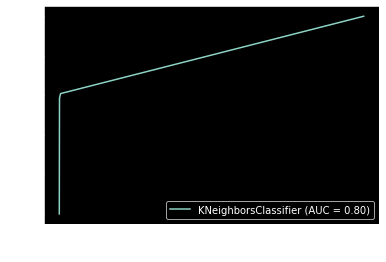

True Negatives (Non-outliers)                           4343
False Positives (Non-outliers predicted as outliers)       3
False Negatives (Outliers predicted as non-outliers       19
True Positives (Outliers)                                 27
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      1.00      1.00      4346
     Outlier       0.90      0.59      0.71        46

    accuracy                           0.99      4392
   macro avg       0.95      0.79      0.85      4392
weighted avg       0.99      0.99      0.99      4392



In [13]:
n_neighbors = 5

def run_knn():
    print("Running K Nearest Neighbors")
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [n_neighbors], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Nearest Neighbors" in run_models:
    run_models_data['knn'] = run_knn()

## Linear SVM

Running Linear SVM


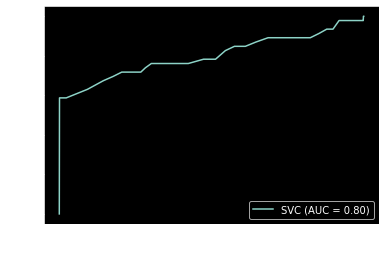

True Negatives (Non-outliers)                           2773
False Positives (Non-outliers predicted as outliers)    1573
False Negatives (Outliers predicted as non-outliers       11
True Positives (Outliers)                                 35
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.64      0.78      4346
     Outlier       0.02      0.76      0.04        46

    accuracy                           0.64      4392
   macro avg       0.51      0.70      0.41      4392
weighted avg       0.99      0.64      0.77      4392



In [14]:
c = 0.025

def run_linear_svm():
    print("Running Linear SVM")
    model = SVC(kernel="linear", C=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [c], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Linear SVM" in run_models:
    run_models_data['linear_svm'] = run_linear_svm()

## RBF SVM

Running RBF SVM


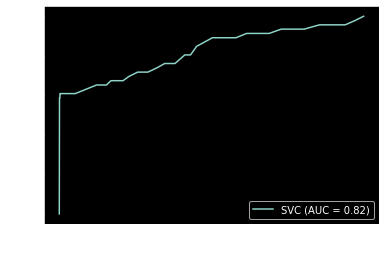

True Negatives (Non-outliers)                           4155
False Positives (Non-outliers predicted as outliers)     191
False Negatives (Outliers predicted as non-outliers       18
True Positives (Outliers)                                 28
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.96      0.98      4346
     Outlier       0.13      0.61      0.21        46

    accuracy                           0.95      4392
   macro avg       0.56      0.78      0.59      4392
weighted avg       0.99      0.95      0.97      4392



In [15]:
gamma=2
c = 1

def run_rbf_svm():
    print("Running RBF SVM")
    model = SVC(gamma=gamma, C=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [gamma, c], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "RBF SVM" in run_models:
    run_models_data['rbf_svm'] = run_rbf_svm()

## Gaussian Process

In [16]:
factor = 1
kernel_factor = 1

def run_gaussian():
    print("Running Gaussian Process")
    model = GaussianProcessClassifier(factor * RBF(kernel_factor))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [factor, kernel_factor], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Gaussian Process" in run_models:
    run_models_data['gaussian'] = run_gaussian()

## Decision Tree

Running Decision Tree


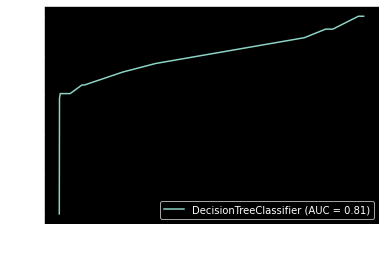

True Negatives (Non-outliers)                           4023
False Positives (Non-outliers predicted as outliers)     323
False Negatives (Outliers predicted as non-outliers       16
True Positives (Outliers)                                 30
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.93      0.96      4346
     Outlier       0.08      0.65      0.15        46

    accuracy                           0.92      4392
   macro avg       0.54      0.79      0.55      4392
weighted avg       0.99      0.92      0.95      4392



In [17]:
max_depth = 5

def run_tree():
    print("Running Decision Tree")
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [max_depth], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Decision Tree" in run_models:
    run_models_data['tree'] = run_tree()

## Random Forests

Running Random Forests


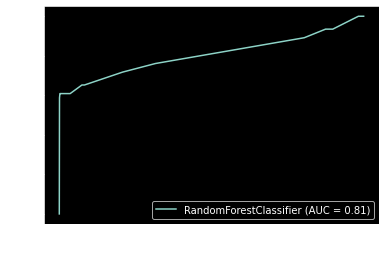

True Negatives (Non-outliers)                           4023
False Positives (Non-outliers predicted as outliers)     323
False Negatives (Outliers predicted as non-outliers       16
True Positives (Outliers)                                 30
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.93      0.96      4346
     Outlier       0.08      0.65      0.15        46

    accuracy                           0.92      4392
   macro avg       0.54      0.79      0.55      4392
weighted avg       0.99      0.92      0.95      4392



In [18]:
max_depth = 5
n_estimators = 10
max_features = 1

def run_forest():
    print("Running Random Forests")
    model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, max_features=max_features)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [max_depth, n_estimators, max_features], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Random Forest" in run_models:
    run_models_data['forest'] = run_forest()

## Neural Net

Running Neural Net


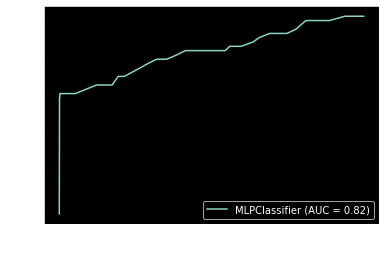

True Negatives (Non-outliers)                           3592
False Positives (Non-outliers predicted as outliers)     754
False Negatives (Outliers predicted as non-outliers       16
True Positives (Outliers)                                 30
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.83      0.90      4346
     Outlier       0.04      0.65      0.07        46

    accuracy                           0.82      4392
   macro avg       0.52      0.74      0.49      4392
weighted avg       0.99      0.82      0.89      4392



In [19]:
alpha = 1
max_iter = 1000

def run_mlp():
    print("Running Neural Net")
    model = MLPClassifier(alpha=alpha, max_iter=max_iter)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [alpha, max_iter], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Neural Net" in run_models:
    run_models_data['mlp'] = run_mlp()

## AdaBoost

Running AdaBoost


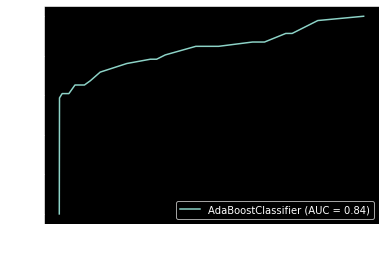

True Negatives (Non-outliers)                           4068
False Positives (Non-outliers predicted as outliers)     278
False Negatives (Outliers predicted as non-outliers       16
True Positives (Outliers)                                 30
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.94      0.97      4346
     Outlier       0.10      0.65      0.17        46

    accuracy                           0.93      4392
   macro avg       0.55      0.79      0.57      4392
weighted avg       0.99      0.93      0.96      4392



In [20]:
def run_adaboost():
    print("Running AdaBoost")
    model = AdaBoostClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "AdaBoost" in run_models:
    run_models_data['adaboost'] = run_adaboost()

## Naive Bayes

Running Naive Bayes


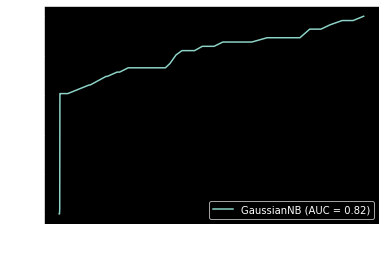

True Negatives (Non-outliers)                           3160
False Positives (Non-outliers predicted as outliers)    1186
False Negatives (Outliers predicted as non-outliers       12
True Positives (Outliers)                                 34
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.73      0.84      4346
     Outlier       0.03      0.74      0.05        46

    accuracy                           0.73      4392
   macro avg       0.51      0.73      0.45      4392
weighted avg       0.99      0.73      0.83      4392



In [21]:
def run_nb():
    print("Running Naive Bayes")
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "Naive Bayes" in run_models:
    run_models_data['nb'] = run_nb()

## Quadratic Discriminant Analyisis

Running Quadratic Discriminant Analysis


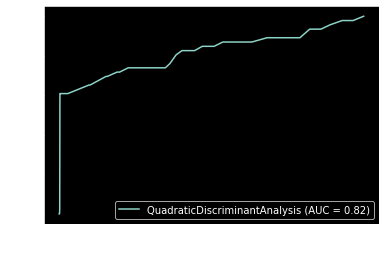

True Negatives (Non-outliers)                           3160
False Positives (Non-outliers predicted as outliers)    1186
False Negatives (Outliers predicted as non-outliers       12
True Positives (Outliers)                                 34
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       1.00      0.73      0.84      4346
     Outlier       0.03      0.74      0.05        46

    accuracy                           0.73      4392
   macro avg       0.51      0.73      0.45      4392
weighted avg       0.99      0.73      0.83      4392



In [22]:
def run_qda():
    print("Running Quadratic Discriminant Analysis")
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    roc_auc = roc_auc_score(y_test, model.predict(X_test))
    precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])
    plot_roc_curve(model, X_test, y_test)
    plt.show()

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
    print(report)
    return [model, [], [accuracy, roc_auc, precision, recall, fscore], report] # model, parameters, metrics, report

if "QDA" in run_models:
    run_models_data['qda'] = run_qda()

# Classification Results

In [23]:
run_models_scores = {k:v[2] for (k, v) in run_models_data.items()}
run_models_scores_df = pd.DataFrame(run_models_scores, index = ['accuracy', 'roc_auc', 'precision', 'recall', 'fscore'])
run_models_scores_df

,knn,linear_svm,rbf_svm,tree,forest,mlp,adaboost,nb,qda
accuracy,0.994991,0.639344,0.952413,0.922814,0.922814,0.824681,0.933060,0.727231,0.727231
roc_auc,0.803280,0.699464,0.782374,0.788926,0.788926,0.739341,0.794104,0.733118,0.733118
precision,0.947822,0.508908,0.561770,0.540512,0.540512,0.516915,0.546742,0.512043,0.512043
recall,0.793133,0.699464,0.782374,0.788926,0.788926,0.739341,0.794104,0.733118,0.733118
fscore,0.854000,0.410081,0.593394,0.554973,0.554973,0.487741,0.567308,0.447181,0.447181


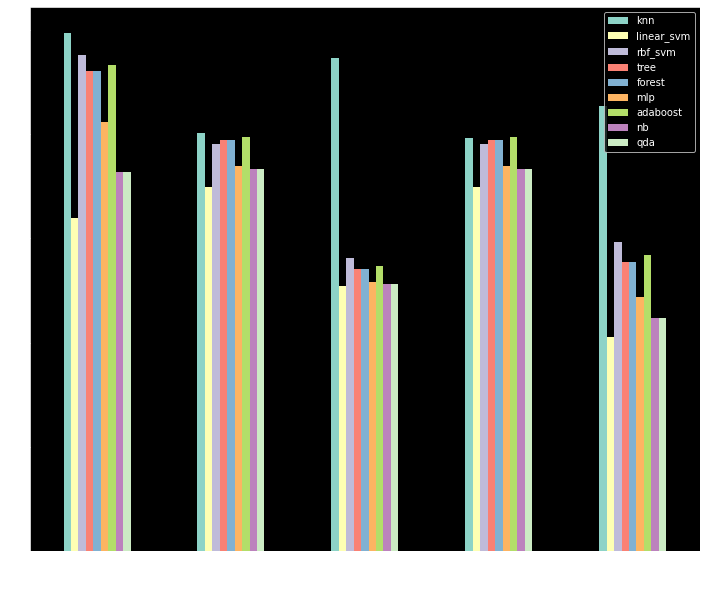

In [24]:
run_models_scores_df.plot(kind='bar', figsize=(12, 10))
plt.show()

## Outlier Prediction

In [40]:
show_model_prediction = "knn" # ["knn", "linear_svm", "rbf_svm", "gaussian", "tree", "forest", "mlp", "adaboost", "nb", "qda"]

show_model = run_models_data[show_model_prediction][0]
y_pred = show_model.predict(X_test)
pred = pd.concat([X_test, pd.DataFrame(y_pred, columns=['outlier'])], axis=1)
pred

,value,outlier
0,0.417942,0
1,0.334008,0
2,0.082205,0
3,1.005482,0
4,-0.757137,0
...,...,...
4387,0.753680,0
4388,0.753680,0
4389,0.753680,0
4390,-0.001729,0


## Which metric to optimise

In [25]:
df_best = run_models_scores_df.idxmax(axis=1)
df_best

accuracy          knn
roc_auc           knn
precision         knn
recall       adaboost
fscore            knn
dtype: object

In [26]:
optimise_metric = 'accuracy' # ['accuracy', 'roc_auc', 'precision', 'recall', 'fscore']
best = df_best[optimise_metric]
print(run_models_data[best][3])

              precision    recall  f1-score   support

 Non-outlier       1.00      1.00      1.00      4346
     Outlier       0.90      0.59      0.71        46

    accuracy                           0.99      4392
   macro avg       0.95      0.79      0.85      4392
weighted avg       0.99      0.99      0.99      4392



Export the data

In [27]:
dump([run_models_data[best], df, time_series, scaler], './../out/supervised_model.joblib')

['./../out/supervised_model.joblib']